# Exploration of DES experimental design data
Data collected by Maria Politi

## Purpose of this notebook
The goal here is to explore the data and create models parallel to methods that we want to teach in DIRECT. For which data science topics might this data be sufficient?

__Ideas__:
1. Distribution exploration
2. Unsupervised/embedding
2. Supervised ML basics
3. Featurization and encodings
4. Data splitting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')

## 1. Distribution Exploration

What are the fields within the dataset and can we observe any relationships

In [2]:
data_raw = pd.read_csv('politi_des.csv', index_col=0).reset_index(drop=True)

In [3]:
data_raw.describe()

,run,QAS_xf,HBD_xf,conductivity,cathodic_slope,anodic_slope,cathodic_potential,anodic_potential,potential_window
count,600.000000,600.000000,600.000000,230.000000,230.000000,230.000000,195.000000,195.000000,195.000000
mean,1.200000,0.487500,0.512500,1.521357,1.252883,1.238013,-1.911533,1.226564,3.138123
std,0.748956,0.228522,0.228522,2.348966,1.137035,1.286225,0.330444,0.198202,0.403170
min,0.000000,0.100000,0.100000,0.001000,0.003000,0.001000,-3.616000,0.936000,2.272000
25%,1.000000,0.337500,0.375000,0.220750,0.364500,0.295500,-1.897500,1.162000,2.962000
50%,1.000000,0.475000,0.525000,0.668500,0.818500,0.699000,-1.843000,1.195000,3.032000
75%,2.000000,0.625000,0.662500,1.709500,1.953250,1.819250,-1.784000,1.231500,3.139500
max,2.000000,0.900000,0.900000,19.630000,4.398000,5.758000,-1.137000,2.904000,4.898000


In [4]:
data_raw.columns

Index(['run', 'sample_id', 'new_ID', 'QAS', 'HBD', 'QAS_xf', 'HBD_xf',
       'conductivity', 'cathodic_slope', 'anodic_slope', 'cathodic_potential',
       'anodic_potential', 'potential_window'],
      dtype='object')

We can see by the count that some of the measurements are missing for some examples:

In [5]:
data_raw.isna().sum(axis=0)

run                     0
sample_id               0
new_ID                  0
QAS                     0
HBD                     0
QAS_xf                  0
HBD_xf                  0
conductivity          370
cathodic_slope        370
anodic_slope          370
cathodic_potential    405
anodic_potential      405
potential_window      405
dtype: int64

label solids by has NA data

In [6]:
data = data_raw.copy()

In [7]:
data['solid'] = data[['conductivity', 'cathodic_slope', 'anodic_slope', 'cathodic_potential',
       'anodic_potential', 'potential_window']].isna().any(axis=1)

In [8]:
data['solid'].sum()

405

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


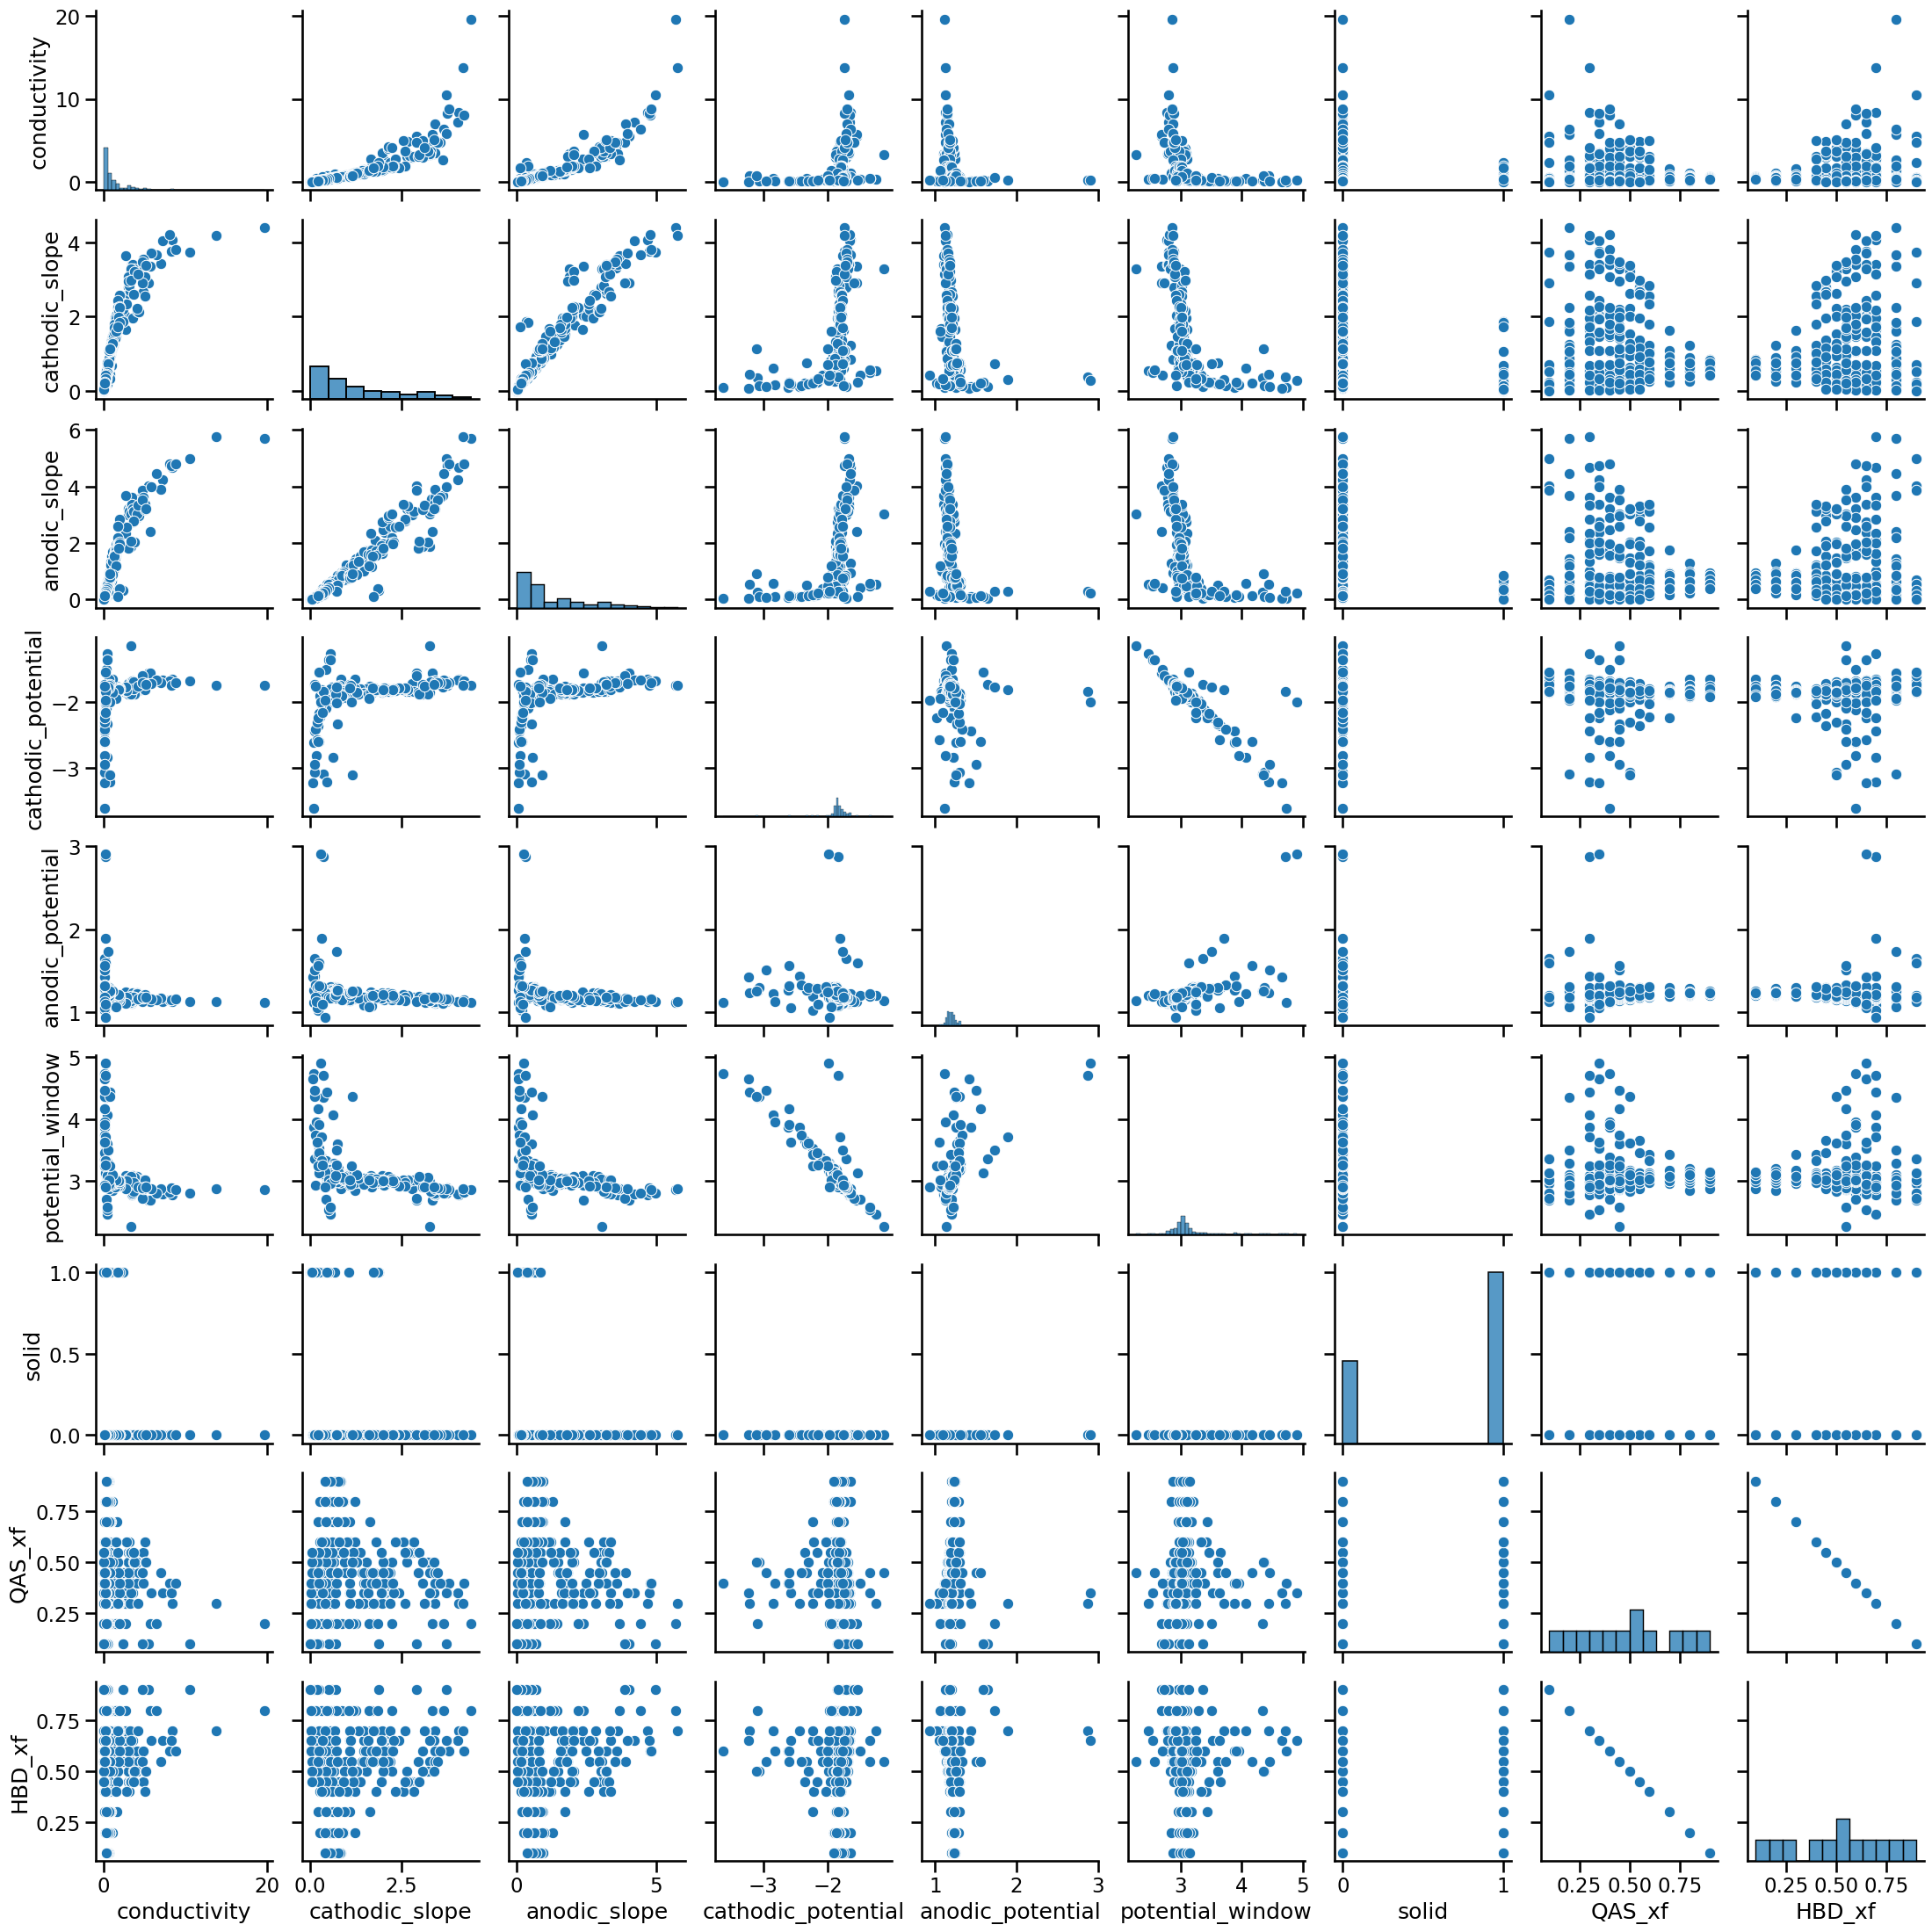

In [9]:
sns.pairplot(data[['conductivity', 'cathodic_slope', 'anodic_slope', 'cathodic_potential',
       'anodic_potential', 'potential_window', 'solid', 'QAS', 'HBD', 'QAS_xf', 'HBD_xf']])

There are clearly relationships between the measurements at least.

In [10]:
data_raw['QAS'].unique()

array(['Choline Chloride', 'Acetylcholine Chloride',
       'Tetraethylammonium Chloride', 'Tetrapropylammonium Bromide',
       'Tetraethylammonium Iodide'], dtype=object)

In [11]:
data_raw['HBD'].unique()

array(['Ethylene Glycol', 'Glycerol', 'Acetamide', 'N,N-dimethylurea',
       '3-phenylpropionic acid', 'Urea', 'L-serine', '4-amino triazole',
       'Xylitol', 'Phenylacetic acid'], dtype=object)

## 3. Basic supervised ML

Try a knn to predict regression and classification task

In [12]:
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.neighbors
import sklearn.metrics

In [13]:
train, test = sklearn.model_selection.train_test_split(data, test_size=0.15)

All further determination of a model uses the training set.

In [14]:
def get_Xy(data: pd.DataFrame, features: list, target: str):
    X = data[features].values
    y = data[target].values
    return X, y

In [15]:
train_X, train_y = get_Xy(train, features=['QAS', 'HBD', 'QAS_xf'], target='solid')

In [16]:
train_X

array([['Acetylcholine Chloride', 'Xylitol', 0.9],
       ['Choline Chloride', 'Glycerol', 0.3],
       ['Acetylcholine Chloride', 'N,N-dimethylurea', 0.2],
       ...,
       ['Choline Chloride', 'N,N-dimethylurea', 0.55],
       ['Acetylcholine Chloride', 'Ethylene Glycol', 0.4],
       ['Acetylcholine Chloride', '3-phenylpropionic acid', 0.6]],
      dtype=object)

Discuss encoding here - what can computers understand. Cute picture

In [17]:
train_X_cat = train_X[:,:2]
train_X_cont = train_X[:,2:].reshape(-1,1)

In [18]:
X_encoder = sklearn.preprocessing.OneHotEncoder(sparse=False)
train_X_cat = X_encoder.fit_transform(train_X_cat)
print(train_X_cat.shape)
print(train_X_cont.shape)

(510, 15)
(510, 1)


In [19]:
X_encoder.get_feature_names()

/Users/ek/miniconda3/envs/DIRECT_dataset_testing/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['x0_Acetylcholine Chloride', 'x0_Choline Chloride',
       'x0_Tetraethylammonium Chloride', 'x0_Tetraethylammonium Iodide',
       'x0_Tetrapropylammonium Bromide', 'x1_3-phenylpropionic acid',
       'x1_4-amino triazole', 'x1_Acetamide', 'x1_Ethylene Glycol',
       'x1_Glycerol', 'x1_L-serine', 'x1_N,N-dimethylurea',
       'x1_Phenylacetic acid', 'x1_Urea', 'x1_Xylitol'], dtype=object)

In [20]:
train_X = np.hstack([train_X_cat, train_X_cont])

In [21]:
print(f"Input feature size {train_X.shape[1]}")

Input feature size 16


In [22]:
norm = sklearn.preprocessing.StandardScaler()
train_X = norm.fit_transform(train_X)

In [23]:
model = sklearn.neighbors.KNeighborsClassifier()
model.fit(train_X, train_y)

KNeighborsClassifier()

Now evaluate

In [24]:
test_X, test_y = get_Xy(test, features=['QAS', 'HBD', 'QAS_xf'], target='solid')

In [25]:
test_X_cat = test_X[:,:2]
test_X_cont = test_X[:,2:].reshape(-1,1)
test_X_cat = X_encoder.transform(test_X_cat)
test_X = np.hstack([test_X_cat, test_X_cont])
test_X = norm.transform(test_X)

In [26]:
preds_y = model.predict(test_X)

What is the baseline accuracy? This is achieved by guessing the majority class always.

In [27]:
majority_class = np.bincount(test_y).argmax()

In [29]:
sklearn.metrics.accuracy_score(test_y, np.ones(test_y.shape)*majority_class)

0.7111111111111111

In [30]:
sklearn.metrics.accuracy_score(test_y, preds_y)

0.9

/Users/ek/miniconda3/envs/DIRECT_dataset_testing/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


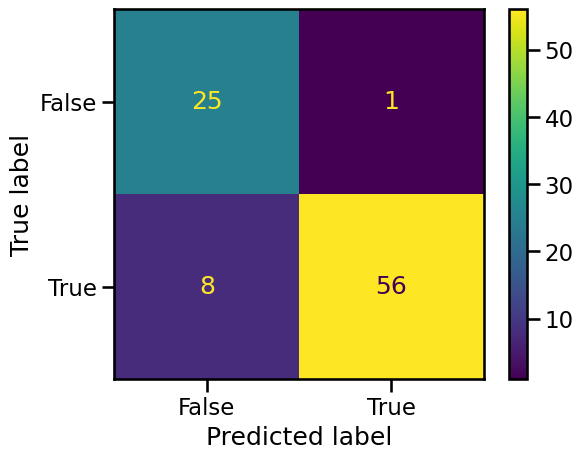

In [31]:
sklearn.metrics.plot_confusion_matrix(model, test_X, test_y)

We achieve a useful predictor __for this test set__.

let's look at the distribution of features between train and test - for kicks consider the first and last faeture. The first is a one hot of a compound, and the last is a compound ratio.

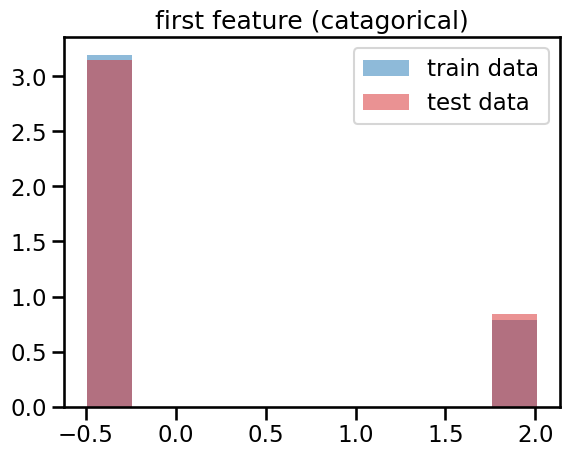

In [32]:
fig, ax = plt.subplots()
ax.hist(train_X[:,0], color='tab:blue', label='train data', alpha=.5, density=True)
ax.hist(test_X[:,0], color='tab:red', label='test data', alpha=.5, density=True)
ax.set_title('first feature (catagorical)')
plt.legend()

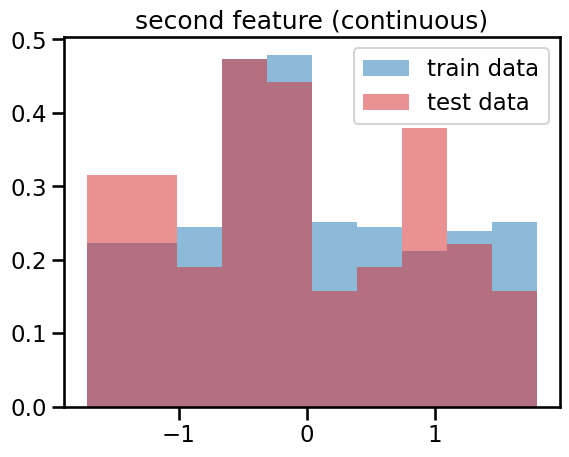

In [33]:
fig, ax = plt.subplots()
ax.hist(train_X[:,-1], color='tab:blue', label='train data', alpha=.5, density=True)
ax.hist(test_X[:,-1], color='tab:red', label='test data', alpha=.5, density=True)
ax.set_title('second feature (continuous)')
plt.legend()

## 3. Featurization

What if the test set contained a compound not seen in training?

In [34]:
def train_test_holdout_qas_compound(data: pd.DataFrame, test_qas_compound: str = 'Tetrapropylammonium Bromide'):
    test_mask = data['QAS'] == test_qas_compound
    return data[~test_mask], data[test_mask]

In [35]:
train, test = train_test_holdout_qas_compound(data)

In [40]:
train_X, train_y = get_Xy(train, features=['QAS', 'HBD', 'QAS_xf'], target='solid')

In [41]:
train_X

array([['Choline Chloride', 'Ethylene Glycol', 0.1],
       ['Choline Chloride', 'Ethylene Glycol', 0.2],
       ['Choline Chloride', 'Ethylene Glycol', 0.3],
       ...,
       ['Tetraethylammonium Iodide', 'Phenylacetic acid', 0.7],
       ['Tetraethylammonium Iodide', 'Phenylacetic acid', 0.8],
       ['Tetraethylammonium Iodide', 'Phenylacetic acid', 0.9]],
      dtype=object)

In [42]:
train_X_cat = train_X[:,:2]
train_X_cont = train_X[:,2:].reshape(-1,1)

In [43]:
X_encoder = sklearn.preprocessing.OneHotEncoder(sparse=False)
train_X_cat = X_encoder.fit_transform(train_X_cat)
print(train_X_cat.shape)
print(train_X_cont.shape)

(480, 14)
(480, 1)


In [44]:
X_encoder.get_feature_names()

/Users/ek/miniconda3/envs/DIRECT_dataset_testing/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['x0_Acetylcholine Chloride', 'x0_Choline Chloride',
       'x0_Tetraethylammonium Chloride', 'x0_Tetraethylammonium Iodide',
       'x1_3-phenylpropionic acid', 'x1_4-amino triazole', 'x1_Acetamide',
       'x1_Ethylene Glycol', 'x1_Glycerol', 'x1_L-serine',
       'x1_N,N-dimethylurea', 'x1_Phenylacetic acid', 'x1_Urea',
       'x1_Xylitol'], dtype=object)

In [45]:
test_X, test_y = get_Xy(test, features=['QAS', 'HBD', 'QAS_xf'], target='solid')
test_X_cat = test_X[:,:2]
test_X_cont = test_X[:,2:].reshape(-1,1)
test_X_cat = X_encoder.transform(test_X_cat)
test_X = np.hstack([test_X_cat, test_X_cont])

ValueError: Found unknown categories ['Tetrapropylammonium Bromide'] in column 0 during transform

We could not encode our compounds for the test set because the QAS in the test set is not in training! It doesn't have a position!

For the sake of argument, let's fake it so that all compounds can be encoded, even if they do not occur in the training set.

In [46]:
all_possible_qas = np.tile(data['QAS'].unique().reshape(-1,1), (2,1))
all_possible_hbd = data['HBD'].unique().reshape(-1,1)
all_possible_compounds = np.hstack([all_possible_qas, all_possible_hbd])

In [47]:
all_possible_compounds

array([['Choline Chloride', 'Ethylene Glycol'],
       ['Acetylcholine Chloride', 'Glycerol'],
       ['Tetraethylammonium Chloride', 'Acetamide'],
       ['Tetrapropylammonium Bromide', 'N,N-dimethylurea'],
       ['Tetraethylammonium Iodide', '3-phenylpropionic acid'],
       ['Choline Chloride', 'Urea'],
       ['Acetylcholine Chloride', 'L-serine'],
       ['Tetraethylammonium Chloride', '4-amino triazole'],
       ['Tetrapropylammonium Bromide', 'Xylitol'],
       ['Tetraethylammonium Iodide', 'Phenylacetic acid']], dtype=object)

In [48]:
X_encoder = sklearn.preprocessing.OneHotEncoder(sparse=False)
X_encoder.fit(all_possible_compounds)

OneHotEncoder(sparse=False)

Now encode the actual data

In [49]:
train_X, train_y = get_Xy(train, features=['QAS', 'HBD', 'QAS_xf'], target='solid')
train_X_cat = train_X[:,:2]
train_X_cont = train_X[:,2:].reshape(-1,1)
train_X_cat = X_encoder.transform(train_X_cat)
train_X = np.hstack([train_X_cat, train_X_cont])
norm = sklearn.preprocessing.StandardScaler()
train_X = norm.fit_transform(train_X)

In [50]:
test_X, test_y = get_Xy(test, features=['QAS', 'HBD', 'QAS_xf'], target='solid')
test_X_cat = test_X[:,:2]
test_X_cont = test_X[:,2:].reshape(-1,1)
test_X_cat = X_encoder.transform(test_X_cat)
test_X = np.hstack([test_X_cat, test_X_cont])
test_X = norm.transform(test_X)

In [51]:
model = sklearn.neighbors.KNeighborsClassifier()
model.fit(train_X, train_y)

KNeighborsClassifier()

Now evaluate

In [52]:
preds_y = model.predict(test_X)

In [53]:
sklearn.metrics.accuracy_score(test_y, preds_y)

0.6416666666666667

/Users/ek/miniconda3/envs/DIRECT_dataset_testing/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


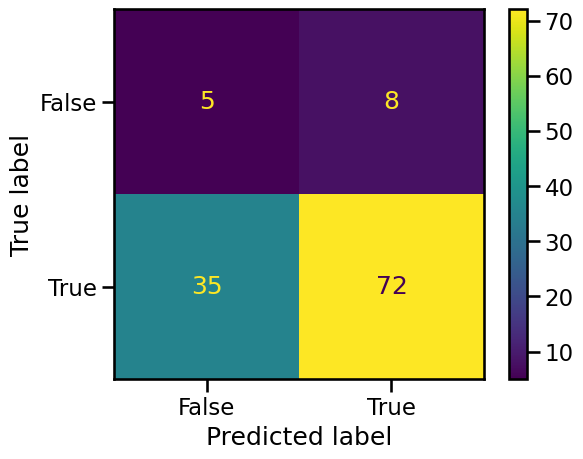

In [54]:
sklearn.metrics.plot_confusion_matrix(model, test_X, test_y)

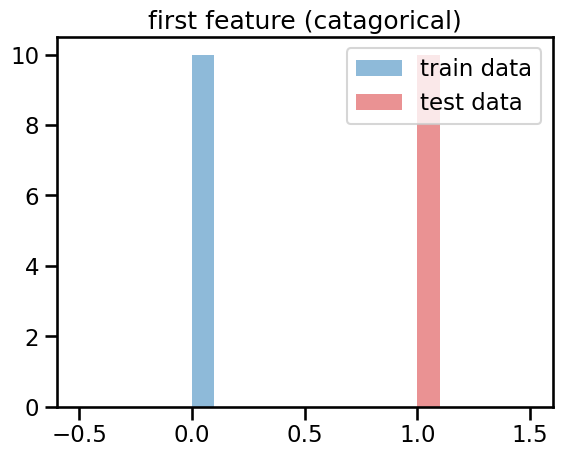

In [55]:
fig, ax = plt.subplots()
ax.hist(train_X[:,4], color='tab:blue', label='train data', alpha=.5, density=True)
ax.hist(test_X[:,4], color='tab:red', label='test data', alpha=.5, density=True)
ax.set_title('first feature (catagorical)')
plt.legend()

We can see that there is no overlap whatsoever in the distribution of the second feature (the indicator for QAS being the compound we seperated out). Thus it is purely extrapolating the test set!

In [56]:
import rdkit.Chem as Chem
import rdkit.Chem.Descriptors as D
import rdkit.Chem.Lipinski

In [57]:
names = {
    'Choline Chloride': '[Cl-].OCC[N+](C)(C)C',
    'Acetylcholine Chloride': 'CC(=O)OCC[N+](C)(C)C.[Cl-]',
    'Tetraethylammonium Chloride': 'CC[N+](CC)(CC)CC.[Cl-]',
    'Tetrapropylammonium Bromide': 'CCC[N+](CCC)(CCC)CCC.[Br-]',
    'Tetraethylammonium Iodide': 'CC[N+](CC)(CC)CC.[I-]'
}

In [58]:
mps = {
    'Choline Chloride': 302,
    'Acetylcholine Chloride': 150,
    'Tetraethylammonium Chloride': 360,
    'Tetrapropylammonium Bromide': 286,
    'Tetraethylammonium Iodide': 280
}

In [59]:
qas_features = {}
for qas in np.unique(all_possible_compounds[:,0]):
    smiles = names[qas]
    mol = Chem.MolFromSmiles(smiles)

    if 'Cl' in smiles:
        halide_indicator = 1
    elif 'Br' in smiles:
        halide_indicator = 2
    else:
        halide_indicator = 3
    features = [D.ExactMolWt(mol), mps[qas], halide_indicator]
    
    qas_features[qas] = features

In [60]:
qas_features

{'Acetylcholine Chloride': [181.086956432, 150, 1],
 'Choline Chloride': [139.076391748, 302, 1],
 'Tetraethylammonium Chloride': [165.12842732, 360, 1],
 'Tetraethylammonium Iodide': [257.06404764, 280, 3],
 'Tetrapropylammonium Bromide': [265.140511996, 286, 2]}

In [61]:
names = {
    'Ethylene Glycol': 'OCCO',
    'Glycerol': 'C(C(CO)O)O',
    'Acetamide': 'CC(=O)N',
    'N,N-dimethylurea': 'CNC(=O)NC',
    '3-phenylpropionic acid': 'C1=CC=C(C=C1)CCC(=O)O',
    'Urea': 'C(=O)(N)N',
    'L-serine': 'C(C(C(=O)O)N)O',
    '4-amino triazole': 'C1=NN=CN1N',
    'Xylitol': 'C(C(C(C(CO)O)O)O)O',
    'Phenylacetic acid': 'O=C(O)Cc1ccccc1'
}

In [62]:
mps = {
    'Ethylene Glycol': -12.9,
    'Glycerol': 17.8,
    'Acetamide': 80,
    'N,N-dimethylurea': 183,
    '3-phenylpropionic acid': 48,
    'Urea': 133,
    'L-serine': 222,
    '4-amino triazole': 86,
    'Xylitol': 92,
    'Phenylacetic acid': 256.5
}

In [63]:
hbd_features = {}
for hbd in np.unique(all_possible_compounds[:,1]):
    smiles = names[hbd]
    mol = Chem.MolFromSmiles(smiles)

    features = [D.ExactMolWt(mol), mps[hbd], rdkit.Chem.Lipinski.NumHDonors(mol)]
    
    hbd_features[hbd] = features

In [64]:
hbd_features

{'3-phenylpropionic acid': [150.06807956, 48, 1],
 '4-amino triazole': [84.04359612799999, 86, 1],
 'Acetamide': [59.03711378, 80, 1],
 'Ethylene Glycol': [62.036779432, -12.9, 2],
 'Glycerol': [92.047344116, 17.8, 3],
 'L-serine': [105.042593084, 222, 3],
 'N,N-dimethylurea': [88.063662876, 183, 2],
 'Phenylacetic acid': [136.052429496, 256.5, 1],
 'Urea': [60.032362748, 133, 2],
 'Xylitol': [152.068473484, 92, 5]}

In [65]:
def get_features(X):
    X_qas = np.array([qas_features[qas] for qas in X[:,0]])
    X_hbd = np.array([hbd_features[hbd] for hbd in X[:,1]])
    X = np.hstack([X_qas, X_hbd, X[:,2].reshape(-1,1)])
    return X

In [66]:
train_X, train_y = get_Xy(train, features=['QAS', 'HBD', 'QAS_xf'], target='solid')
test_X, test_y = get_Xy(test, features=['QAS', 'HBD', 'QAS_xf'], target='solid')

In [67]:
train_X = get_features(train_X)
test_X = get_features(test_X)

In [68]:
norm = sklearn.preprocessing.StandardScaler()
train_X = norm.fit_transform(train_X)
test_X = norm.transform(test_X)

/Users/ek/miniconda3/envs/DIRECT_dataset_testing/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


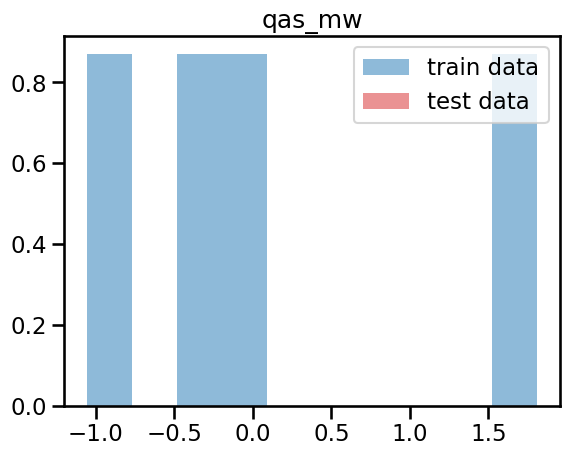

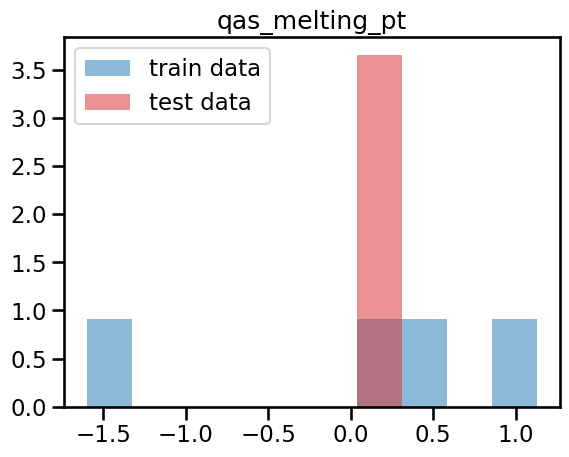

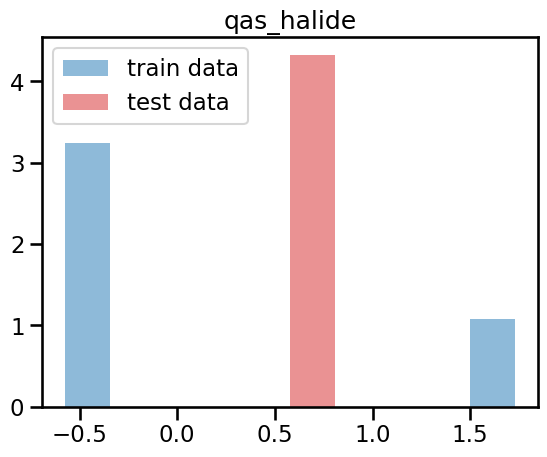

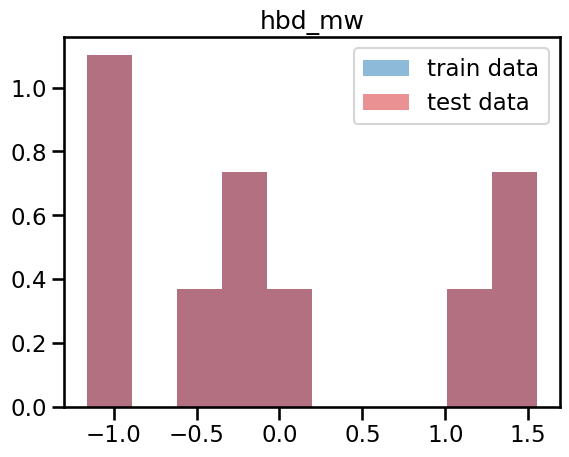

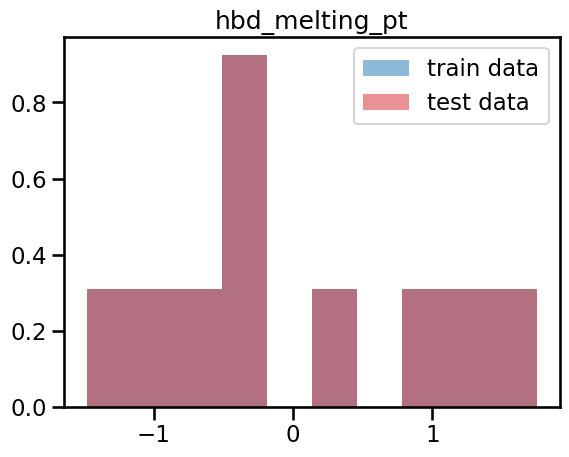

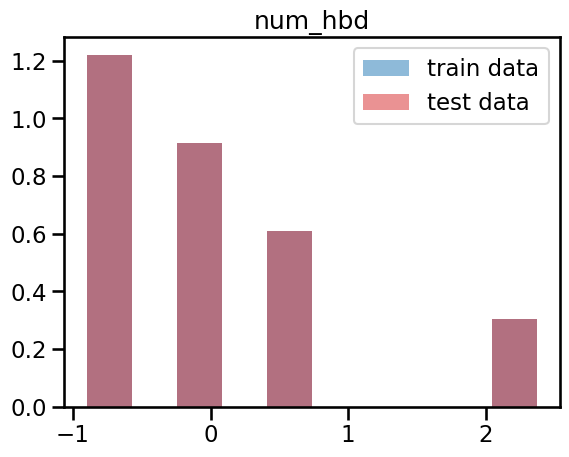

In [69]:
for i, feature_name in enumerate(['qas_mw', 'qas_melting_pt', 'qas_halide', 'hbd_mw', 'hbd_melting_pt', 'num_hbd']):
    fig, ax = plt.subplots()
    
    # get bin edges
    right = max([max(train_X[:,i]), max(test_X[:,i])])
    left = min([min(train_X[:,i]), min(test_X[:,i])])
    delta = (right - left)/10
    bins = [left+delta*i for i in range(11)]
    
    ax.hist(train_X[:,i], color='tab:blue', label='train data', alpha=.5, bins=bins, density=True)
    ax.hist(test_X[:,i], color='tab:red', label='test data', alpha=.5, density=True, bins=bins)
    ax.set_title(feature_name)
    plt.legend()
    plt.show()
    plt.close()

In [70]:
model = sklearn.neighbors.KNeighborsClassifier()
model.fit(train_X, train_y)

KNeighborsClassifier()

Now evaluate

In [71]:
preds_y = model.predict(test_X)

In [72]:
sklearn.metrics.accuracy_score(test_y, preds_y)

0.8916666666666667

/Users/ek/miniconda3/envs/DIRECT_dataset_testing/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


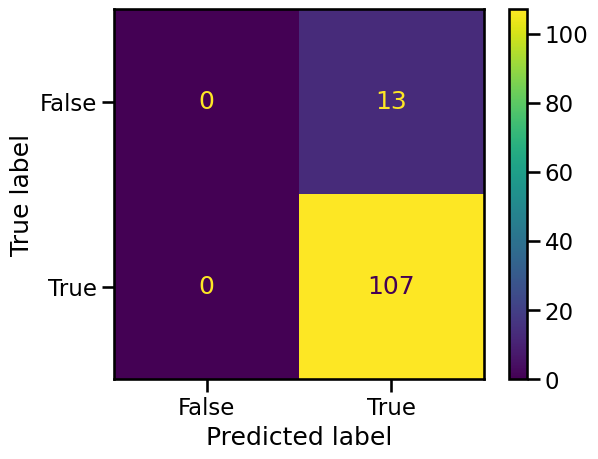

In [73]:
sklearn.metrics.plot_confusion_matrix(model, test_X, test_y)

We did a better job by featurizing!